### Dzenan Hamzic BSc, TU Wien

#### Data : 184.702 TU ML WS 18 - Student Performance (Kaggle)
#### Group 15
https://www.kaggle.com/c/184702-tu-ml-ws-18-student-performance/data

In [2]:
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statistics
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn import neighbors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

plt.rcParams['figure.figsize'] = (14.0, 6.0)

In [71]:
class Performance:
    @staticmethod
    def get_perf(y, y_pred):
        ''' This method outputs several performance metrics for classification. '''

        # ‘explained_variance’
        explained_variance = metrics.explained_variance_score(y_true = y, y_pred = y_pred)

        # R2
        r2 = metrics.r2_score(y_true = y, y_pred = y_pred)

        # ‘neg_mean_absolute_error’
        mean_abs_err = metrics.mean_absolute_error(y_true = y, y_pred = y_pred)
        
        # ‘neg_mean_squared_error’
        mean_sq_err = np.sqrt(metrics.mean_squared_error(y_true = y, y_pred = y_pred))
        
        return {'expl_variance': np.round(explained_variance, 6), 'R2': np.round(r2, 6),
                'mean_abs_err': np.round(mean_abs_err,6), 'r_mean_sq_err': np.round(mean_sq_err,6)}
   

''' Run tests with default algorithm settings '''
def run_tests(test_size, setting, X_train, X_test, y_train, y_test, log = False):
    rstate = 1234
    # algorithms
    algo_names = ["BaggingRegressor",
                   "RandomForestRegressor",
                  "BayesianRidge-Score",
                  "GradientBoosting",
                  "LinearRegression-NonNorm",
                  "LinearRegression-Norm-NoInterc",
                  "DecisionTreeRegressor-",
                  "Ridge",
                  "Ridge-Alpha001",
                  "KNRegressor-distanceN5",
                  "KNRegressor-distanceN50",
                 "KNRegressor-uniformN5"]
    
    algo_list = [BaggingRegressor(),
                RandomForestRegressor(criterion='mse', oob_score=True),
                BayesianRidge(compute_score=True),
                 GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=5, random_state=1607, loss='ls'),
                 LinearRegression(normalize=False),
                 LinearRegression(normalize=True, fit_intercept=False),
                tree.DecisionTreeRegressor(),
                linear_model.Ridge(),
                 linear_model.Ridge(alpha=.001),
                neighbors.KNeighborsRegressor(5, weights="distance"),
                neighbors.KNeighborsRegressor(50, weights="distance"),
                neighbors.KNeighborsRegressor(5, weights="uniform")]
    
    assert len(algo_names) == len(algo_list)
    
    # save prediction values
    predictionDf = pd.DataFrame()
    predictionDf["actual"] = y_test.cumsum()
    
    performanceDf = pd.DataFrame()
    for algo,name in zip(algo_list, algo_names):
        if log: print(algo,setting)
        algo_instance = algo

        t0=time.time()
        if log: print(name,"...fit")
        algo.fit(X_train, y_train)
        fit_time = round(time.time()-t0, 3)

        ## And score it on your testing data.
        if log: print(name,"...score")
        score = algo.score(X_test, y_test)

        ## prediction quality measures
        t0=time.time()
        if log: print(name,"...predict")
        y_predict = algo.predict(X_test)
        #y_predict = np.ceil(y_predict)
        pred_time = round(time.time()-t0, 3)
        
        if log: 
            print(name,"...performance")
            print(Performance.get_perf(y_test, y_predict))
            
        predictionDf[name] = y_predict.cumsum()    
            
        pp = Performance.get_perf(y_test, y_predict)
        pp["Algorithm"] = name
        pp["Setting"] = setting
        pp["fit_time"] = fit_time
        pp["pred_time"] = pred_time
        pp["score"] = score
        pp["testSize"] = test_size
        pp["Xsize"] = str(X_train.shape)
        
        pd2 = pd.DataFrame(pp, index=[0])
        performanceDf = pd.concat([performanceDf ,pd2])
        performanceDf.sort_values(by=['R2'], ascending=False, inplace=True)
        
        
    return [performanceDf, predictionDf]
                  

In [4]:
df = pd.read_csv('/home/xxx/MScBI/S4/ML/exer2/data/all/StudentPerformance.shuf.train.csv', sep = ',')
# shuffle
df = df.sample(frac=1, random_state=1607).reset_index(drop=True)
df_test = pd.read_csv('/home/xxx/MScBI/S4/ML/exer2/data/all/StudentPerformance.shuf.test.csv', sep = ',')

In [5]:
df.head()

,id,Grade,school,sex,age,address,famsize,Pstatus,Medu,Fedu,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,360,16,MS,F,18,U,LE3,T,1,1,...,yes,yes,no,5,3,2,1,1,4,0
1,394,10,MS,M,18,R,LE3,T,3,2,...,yes,yes,no,4,4,1,3,4,5,0
2,287,19,GP,F,18,U,GT3,T,2,2,...,yes,yes,no,4,3,3,1,2,2,5
3,20,10,GP,M,16,U,LE3,T,4,3,...,yes,yes,no,3,1,3,1,3,5,4
4,317,0,GP,F,18,U,GT3,T,2,1,...,yes,yes,no,5,3,3,1,2,1,0


### Dummify

In [6]:
train_grade_values = df["Grade"]
df_copy = df.drop(["Grade"], axis=1)

# align with test frame
print(df_copy.shape, df_test.shape)
dfb = pd.concat([df_copy,df_test], axis=0)
print(dfb.shape)

(198, 31) (197, 31)
(395, 31)


In [7]:
df_dummy = pd.get_dummies(dfb)
df_dummy.head()

,id,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,360,18,1,1,2,3,0,5,3,2,...,1,0,0,1,0,1,0,1,1,0
1,394,18,3,2,3,1,0,4,4,1,...,1,0,1,0,0,1,0,1,1,0
2,287,18,2,2,1,3,0,4,3,3,...,1,0,0,1,0,1,0,1,1,0
3,20,16,4,3,1,1,0,3,1,3,...,0,1,0,1,0,1,0,1,1,0
4,317,18,2,1,2,2,0,5,3,3,...,0,1,0,1,0,1,0,1,1,0


In [8]:
df_dummy.shape

(395, 57)

In [9]:
## split df_dummy back to train and test
df_dummy_train = df_dummy.iloc[0:198]
df_dummy_test = df_dummy.iloc[198:395]
# return y to train dummy df
df_dummy_train["Grade"] = train_grade_values
print(df_dummy_train.shape,":",df_dummy_test.shape)

(198, 58) : (197, 57)


/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
df_dummy_train.head()

,id,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,...,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,Grade
0,360,18,1,1,2,3,0,5,3,2,...,0,0,1,0,1,0,1,1,0,16
1,394,18,3,2,3,1,0,4,4,1,...,0,1,0,0,1,0,1,1,0,10
2,287,18,2,2,1,3,0,4,3,3,...,0,0,1,0,1,0,1,1,0,19
3,20,16,4,3,1,1,0,3,1,3,...,1,0,1,0,1,0,1,1,0,10
4,317,18,2,1,2,2,0,5,3,3,...,1,0,1,0,1,0,1,1,0,0


### save dummified to scv for R stepwise algorithm

In [11]:
df_dummy_train.to_csv("/home/xxx/MScBI/S4/ML/exer2/data/all/oversampled_student_data_train.csv", index=False, header=True, quoting=csv.QUOTE_NONNUMERIC)

In [12]:
# split to seen and unseen 
X_test_unseen = df_dummy_train.iloc[148:198]
y_test_unseen = X_test_unseen["Grade"]

X_train_seen = df_dummy_train.iloc[0:148]
y_train_seen = X_train_seen["Grade"]

X_train_seen.shape

(148, 58)

### Check Predictor variable distribution

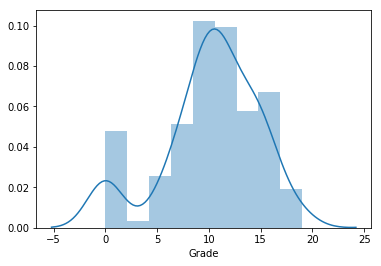

In [13]:
sns.distplot(X_train_seen["Grade"]);

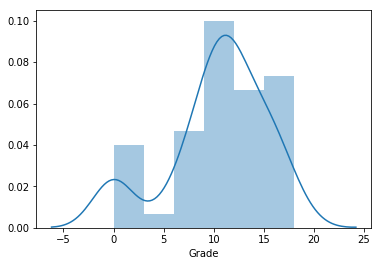

In [14]:
sns.distplot(X_test_unseen["Grade"]);

### Oversampling

In [15]:
number_grades = []
for g in list(set(X_train_seen['Grade'])):
    number_grades.insert(0,len(X_train_seen.loc[df['Grade'] == g]))
    print(g, len(X_train_seen.loc[X_train_seen['Grade'] == g]))

0 15
4 1
5 1
6 7
7 5
8 11
9 11
10 21
11 19
12 12
13 7
14 11
15 14
16 7
17 1
18 3
19 2


In [16]:
most_frequent = 10
most_frequent_len = len(X_train_seen.loc[X_train_seen['Grade'] == most_frequent])
print(most_frequent_len)

21


In [17]:
oversampled_df = X_train_seen.loc[X_train_seen['Grade'] == most_frequent]
for grade in set(X_train_seen['Grade']):
    if grade != most_frequent:
        #print(grade,len(X_train_seen.loc[X_train_seen['Grade'] == grade]))
        subdf = X_train_seen.loc[X_train_seen['Grade'] == grade].sample(n=most_frequent_len, replace=True)
        oversampled_df = oversampled_df.append(subdf)
        
# shuffle
oversampled_df = oversampled_df.sample(frac=1, random_state=1607).reset_index(drop=True)
oversampled_df.shape

(357, 58)

0 21
4 21
5 21
6 21
7 21
8 21
9 21
10 21
11 21
12 21
13 21
14 21
15 21
16 21
17 21
18 21
19 21


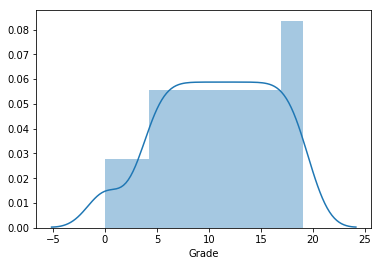

In [18]:
for grade in set(oversampled_df['Grade']):
    print(grade,len(oversampled_df.loc[oversampled_df['Grade'] == grade]))
    
sns.distplot(oversampled_df["Grade"]);

In [19]:
oversampled_df.shape

(357, 58)

### save oversampled to csv

In [20]:
oversampled_df.head()

,id,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,...,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,Grade
0,387,18,4,4,3,1,0,4,4,3,...,1,0,1,0,1,0,1,0,1,6
1,307,20,3,2,1,1,0,5,5,3,...,1,0,1,0,1,1,0,1,0,18
2,234,16,4,4,1,2,0,4,2,4,...,1,0,1,0,1,0,1,1,0,13
3,339,18,3,3,1,4,0,5,3,3,...,0,0,1,0,1,0,1,1,0,17
4,217,17,4,3,1,2,2,3,4,5,...,0,0,1,0,1,0,1,0,1,4


In [21]:
#oversampled_df["Grade"]

### define X and y

In [22]:
# df = balanced_df
y_train = oversampled_df["Grade"]
oversampled_df.drop(["Grade","id"], axis=1, inplace=True)
X_test_unseen.drop(["Grade","id"], axis=1, inplace=True)
X_train = oversampled_df
X_test = X_test_unseen
y_test = y_test_unseen
test_ID_rows = df_test["id"]
df_test.drop(["id"], axis=1, inplace=True)

/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(357, 56) (357,) (50, 56) (50,)


### Check empty values

In [24]:
oversampled_df.isnull().sum()

age                  0
Medu                 0
Fedu                 0
traveltime           0
studytime            0
failures             0
famrel               0
freetime             0
goout                0
Dalc                 0
Walc                 0
health               0
absences             0
school_GP            0
school_MS            0
sex_F                0
sex_M                0
address_R            0
address_U            0
famsize_GT3          0
famsize_LE3          0
Pstatus_A            0
Pstatus_T            0
Mjob_at_home         0
Mjob_health          0
Mjob_other           0
Mjob_services        0
Mjob_teacher         0
Fjob_at_home         0
Fjob_health          0
Fjob_other           0
Fjob_services        0
Fjob_teacher         0
reason_course        0
reason_home          0
reason_other         0
reason_reputation    0
guardian_father      0
guardian_mother      0
guardian_other       0
schoolsup_no         0
schoolsup_yes        0
famsup_no            0
famsup_yes 

### OLS Regression summary

In [25]:
#X = sm.add_constant(X)
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_train)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Grade   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     16.44
Date:                Mon, 07 Jan 2019   Prob (F-statistic):           2.51e-55
Time:                        21:43:22   Log-Likelihood:                -899.57
No. Observations:                 357   AIC:                             1879.
Df Residuals:                     317   BIC:                             2034.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.2650      0.220     -1.203      0.230      -0.699       0.168
Medu                  0.3486      0.361      0.966      0.335      -0.361       1.059
Fedu                 -0.7212      0.270     -2.673      0.008      -1.252      -0.190
traveltime           -0.2343      0.348     -0.674      0.501      -0.918       0.450
studytime             1.3552      0.266      5.099      0.000       0.832       1.878
failures             -1.8196      0.282     -6.443      0.000      -2.375      -1.264
famrel                0.3504      0.249      1.406      0.161      -0.140       0.841
freetime              0.2811      0.264      1.066      0.287      -0.238       0.800
goout                -0.9504      0.275     -3.458      0.001      -1.491      -0.410
Dalc                 -1.1650      0.364     -3.203      0.001      -1.881      -0.449
Walc                  0.5215      0.250      2.085      0.038       0.029       1.014
health               -0.5529      0.167     -3.310      0.001      -0.882      -0.224
absences              0.0026      0.030      0.084      0.933      -0.057       0.063
school_GP             0.9850      0.410      2.403      0.017       0.179       1.791
school_MS             1.2371      0.569      2.175      0.030       0.118       2.356
sex_F                -0.0080      0.410     -0.020      0.984      -0.815       0.799
sex_M                 2.2302      0.362      6.167      0.000       1.519       2.942
address_R             0.1964      0.492      0.399      0.690      -0.771       1.164
address_U             2.0257      0.369      5.487      0.000       1.299       2.752
famsize_GT3           1.0287      0.410      2.509      0.013       0.222       1.836
famsize_LE3           1.1934      0.354      3.367      0.001       0.496       1.891
Pstatus_A             1.8350      0.451      4.065      0.000       0.947       2.723
Pstatus_T             0.3871      0.488      0.793      0.429      -0.574       1.348
Mjob_at_home         -0.4595      0.629     -0.730      0.466      -1.697       0.778
Mjob_health           1.8065      0.805      2.243      0.026       0.222       3.391
Mjob_other            0.2672      0.535      0.499      0.618      -0.786       1.320
Mjob_services        -0.3102      0.493     -0.629      0.530      -1.280       0.660
Mjob_teacher          0.9181      0.716      1.283      0.200      -0.490       2.326
Fjob_at_home          1.3136      0.839      1.566      0.118      -0.336       2.963
Fjob_health          -0.5260      0.812     -0.648      0.517      -2.123       1.071
Fjob_other           -1.2327      0.482     -2.555      0.011      -2.182      -0.284
Fjob_services         0.1899      0.512      0.371      0.711      -0.818       1.198
Fjob_teacher          2.4774      0.887      2.794      0.006       0.733

### execute for no oversampling

In [26]:
# no oversampling
y_train = y_train_seen
X_train = X_train_seen.drop(["Grade","id"], axis=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(148, 56) (148,) (50, 56) (50,)


In [27]:
# implemented above
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1607)


## Setting 1:
 - test data is 25% of the complete dataframe
 - X has dimension of (148, 56)

In [28]:
resultdfs = run_tests(0.25, "raw_data", X_train, X_test, y_train, y_test, False)
resultdfs[0]

/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


,Algorithm,R2,Setting,Xsize,expl_variance,fit_time,mean_abs_err,pred_time,r_mean_sq_err,score,testSize
0,KNRegressor-distanceN5,0.323225,raw_data,"(148, 56)",0.323618,0.001,3.255712,0.001,3.973012,0.323225,0.25
0,RandomForestRegressor,0.323012,raw_data,"(148, 56)",0.323061,0.034,2.982000,0.002,3.973638,0.323012,0.25
0,KNRegressor-uniformN5,0.321786,raw_data,"(148, 56)",0.322149,0.001,3.236000,0.001,3.977235,0.321786,0.25
0,GradientBoosting,0.311805,raw_data,"(148, 56)",0.312163,0.357,2.938091,0.001,4.006393,0.311805,0.25
0,BaggingRegressor,0.311573,raw_data,"(148, 56)",0.312254,0.044,3.066000,0.002,4.007069,0.311573,0.25
0,BayesianRidge-Score,0.226152,raw_data,"(148, 56)",0.227120,0.076,3.345408,0.000,4.248402,0.226152,0.25
0,Ridge,0.203756,raw_data,"(148, 56)",0.208310,0.010,3.536831,0.000,4.309439,0.203756,0.25
0,Ridge-Alpha001,0.194432,raw_data,"(148, 56)",0.199069,0.001,3.563308,0.000,4.334599,0.194432,0.25
0,LinearRegression-NonNorm,0.194421,raw_data,"(148, 56)",0.199059,0.002,3.563337,0.000,4.334627,0.194421,0.25
0,LinearRegression-Norm-NoInterc,0.194421,raw_data,"(148, 56)",0.199059,0.001,3.563337,0.000,4.334627,0.194421,0.25


## Setting 2: regression tests with squared polynomial transformed data
 - test data is 25% of the complete dataframe
 - X has dimension of (148, 1653)

In [77]:
degree = 2
poly = PolynomialFeatures(degree=degree)
X_train_poly2 = poly.fit_transform(X_train)
X_test_poly2 = poly.transform(X_test)

resultdfs = run_tests(0.25, "poly^"+str(degree), X_train_poly2, X_test_poly2, y_train, y_test, False)
resultdfs[0]

/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


,Algorithm,R2,Setting,Xsize,expl_variance,fit_time,mean_abs_err,pred_time,r_mean_sq_err,score,testSize
0,GradientBoosting,0.373514,poly^2,"(148, 1653)",0.373771,3.830,2.949451,0.001,3.822551,0.373514,0.25
0,BaggingRegressor,0.298676,poly^2,"(148, 1653)",0.298767,0.197,3.106000,0.003,4.044428,0.298676,0.25
0,BayesianRidge-Score,0.229179,poly^2,"(148, 1653)",0.229205,0.199,3.320407,0.014,4.240085,0.229179,0.25
0,KNRegressor-uniformN5,0.183900,poly^2,"(148, 1653)",0.186622,0.002,3.348000,0.016,4.362843,0.183900,0.25
0,KNRegressor-distanceN5,0.179482,poly^2,"(148, 1653)",0.182555,0.004,3.379868,0.023,4.374636,0.179482,0.25
0,KNRegressor-distanceN50,0.140186,poly^2,"(148, 1653)",0.144042,0.004,3.378447,0.019,4.478165,0.140186,0.25
0,RandomForestRegressor,-0.008138,poly^2,"(148, 1653)",-0.003802,0.167,3.738000,0.001,4.849062,-0.008138,0.25
0,DecisionTreeRegressor-,-0.519491,poly^2,"(148, 1653)",-0.513934,0.041,4.560000,0.000,5.953150,-0.519491,0.25
0,Ridge,-2.224096,poly^2,"(148, 1653)",-2.189584,0.004,5.981832,0.000,8.671650,-2.224096,0.25
0,LinearRegression-NonNorm,-2.269733,poly^2,"(148, 1653)",-2.233243,0.013,6.015415,0.000,8.732809,-2.269733,0.25


In [58]:
param_grid_bayesian_ridge = {
    "n_estimators":[5000],
    "loss":["ls"],
    "subsample": [1.0],
    "max_features":[2,5,None],
    "learning_rate":[0.1,0.2],
    "max_depth":[2,5,6,7],
    "random_state":[1607]
}

mod = GradientBoostingRegressor()
CV_dtc = GridSearchCV(estimator=mod, param_grid=param_grid_bayesian_ridge, cv = 5, n_jobs=-1)
CV_dtc.fit(X_train_poly2, y_train)
rr_best_params = CV_dtc.best_params_
print("GradientBoostingRegressor - best params: ",rr_best_params)

GradientBoostingRegressor - best params:  {'loss': 'ls', 'learning_rate': 0.1, 'random_state': 1607, 'max_features': 2, 'subsample': 1.0, 'max_depth': 5, 'n_estimators': 5000}


In [78]:
if "Grade" in X_train_poly2:
    X_train_poly2.drop(["Grade"], axis=1, inplace=True)

# bayesian regression
bregr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=5, random_state=1607, loss='ls')
bregr.fit(X_train_poly2, y_train)

# Make predictions using the testing set
y_pred2 = bregr.predict(X_test_poly2)


#print('RR Coefficients: \n', bregr.coef_)
print("R2", bregr.score(X_train_poly2, y_train))
print("RR Mean absolute error: %.5f"% metrics.mean_absolute_error(y_test, y_pred2))
print("RR Mean squared error: %.5f"% np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))
print('RR Variance score: %.2f' % metrics.r2_score(y_test, y_pred2))

/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


R2 0.9999999952170383
RR Mean absolute error: 2.94945
RR Mean squared error: 3.82255
RR Variance score: 0.37


## Setting 3: regression tests with Principal Components
 - test data is 33% of the complete dataframe
 - X has dimension of (148, 5)

In [152]:
from sklearn.decomposition import PCA
# scale
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_pca_scaled = scaler.transform(X_train)
X_test_pca_scaled = scaler.transform(X_test)

pca = PCA(n_components=5)  

# project to PCs
X_train_pca = pca.fit_transform(X_train_pca_scaled)  
X_test_pca = pca.transform(X_test_pca_scaled) 


print(pca.explained_variance_ratio_)  

resultdfs = run_tests(0.7, "PCA10", X_train_pca, X_test_pca, y_train, y_test, False)
resultdfs[0]

[0.09874854 0.06221322 0.05948353 0.05483858 0.04929281]


,Algorithm,R2,Setting,Xsize,expl_variance,fit_time,mean_abs_err,pred_time,r_mean_sq_err,score,testSize
0,LinearRegression-NonNorm,0.126147,PCA10,"(148, 5)",0.126147,0.001,3.554436,0.000,4.514577,0.126147,0.7
0,Ridge-Alpha001,0.126147,PCA10,"(148, 5)",0.126147,0.000,3.554436,0.000,4.514577,0.126147,0.7
0,Ridge,0.126022,PCA10,"(148, 5)",0.126022,0.001,3.554474,0.000,4.514899,0.126022,0.7
0,BayesianRidge-Score,0.094131,PCA10,"(148, 5)",0.094294,0.002,3.563466,0.000,4.596533,0.094131,0.7
0,KNRegressor-distanceN50,0.091163,PCA10,"(148, 5)",0.094996,0.000,3.471908,0.001,4.604059,0.091163,0.7
0,KNRegressor-uniformN5,-0.023307,PCA10,"(148, 5)",-0.021306,0.000,3.744000,0.000,4.885407,-0.023307,0.7
0,KNRegressor-distanceN5,-0.030960,PCA10,"(148, 5)",-0.030241,0.000,3.717268,0.000,4.903641,-0.030960,0.7
0,GradientBoosting,-0.109349,PCA10,"(148, 5)",-0.109187,0.236,3.729957,0.001,5.086649,-0.109349,0.7
0,BaggingRegressor,-0.152970,PCA10,"(148, 5)",-0.152005,0.022,3.918000,0.001,5.185692,-0.152970,0.7
0,RandomForestRegressor,-0.263973,PCA10,"(148, 5)",-0.262392,0.022,4.156000,0.001,5.429586,-0.263973,0.7


## Auto-sklearn Regression

In [48]:
import autosklearn.regression

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

import warnings; warnings.simplefilter('ignore')

import autosklearn.regression

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=4000,
    per_run_time_limit=40,
    #tmp_folder='/tmp/autosklearn_regression_example_tmp',
    #output_folder='/tmp/autosklearn_regression_example_out'
)
print(".... FIT.....")
automl.fit(X_train, y_train)
print(".... FIT... END ...")

print(automl.show_models())
predictions = automl.predict(X_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))

.... FIT.....
[WARNING] [2019-01-06 21:59:42,270:AutoMLSMBO(1)::35c7353c3ab8368acb9f8df4b1e41259] Could not find meta-data directory /home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-01-06 21:59:42,282:EnsembleBuilder(1):35c7353c3ab8368acb9f8df4b1e41259] No models better than random - using Dummy Score!
[WARNING] [2019-01-06 21:59:42,309:EnsembleBuilder(1):35c7353c3ab8368acb9f8df4b1e41259] No models better than random - using Dummy Score!
[22:01:17] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:01:17] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:01:17] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:01:17] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:01:17] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:01:17] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:01:17] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, w

[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:03:08] /workspac

[22:11:26] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:26] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:26] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:26] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:26] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:26] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:26] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:26] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:26] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:26] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:26] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:26] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:27] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:27] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:11:27] /workspac

[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:22:11] /workspac

[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:38] /workspac

[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspac

[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[22:33:39] /workspac

[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[23:02:06] /workspac

R2 score: 0.17531314939689646


## Setting 4: Stepwise algorithm - attribute selection (see R notebook file) 

Using stepwise algorithm in R, we came to the most important features for this data set.

failures + goout + Mjobhealth + Fjobother + freetime + 
    log(studytime) + addressR + sexF + famsupno + schoolsupno

In [153]:
important_features = ["failures","goout","Mjob_health","Fjob_other","freetime", "studytime", "address_R", "sex_F",
         "famsup_no","schoolsup_no"]

#important_features = ["failures" , "Mjob_health" , "traveltime" , "address_R" , "freetime" , 
#    "goout" , "famsup_no" , "reason_reputation" , "Fjob_services" , "studytime" ,
#    "sex_F" , "Dalc"]

X_train2 = X_train[important_features]
X_test2 = X_test[important_features]

In [154]:
X_train2.head()

,failures,goout,Mjob_health,Fjob_other,freetime,studytime,address_R,sex_F,famsup_no,schoolsup_no
0,0,2,0,0,3,3,0,1,1,1
1,0,1,0,1,4,1,1,0,1,1
2,0,3,0,0,3,3,0,1,0,1
3,0,3,1,1,1,1,0,0,1,1
4,0,3,0,1,3,2,0,1,0,1


In [155]:
resultdfs = run_tests(0.33, "raw_data", X_train2, X_test2, y_train, y_test, False)
resultdfs[0]

,Algorithm,R2,Setting,Xsize,expl_variance,fit_time,mean_abs_err,pred_time,r_mean_sq_err,score,testSize
0,Ridge,0.385799,raw_data,"(148, 10)",0.386107,0.001,2.889000,0.000,3.784887,0.385799,0.33
0,Ridge-Alpha001,0.383919,raw_data,"(148, 10)",0.384167,0.001,2.911848,0.000,3.790676,0.383919,0.33
0,LinearRegression-NonNorm,0.383917,raw_data,"(148, 10)",0.384165,0.001,2.911873,0.000,3.790684,0.383917,0.33
0,BayesianRidge-Score,0.378049,raw_data,"(148, 10)",0.378729,0.003,2.879489,0.000,3.808692,0.378049,0.33
0,KNRegressor-uniformN5,0.268415,raw_data,"(148, 10)",0.269930,0.000,3.244000,0.001,4.130763,0.268415,0.33
0,LinearRegression-Norm-NoInterc,0.239556,raw_data,"(148, 10)",0.244175,0.001,3.320701,0.000,4.211448,0.239556,0.33
0,KNRegressor-distanceN5,0.123633,raw_data,"(148, 10)",0.126613,0.000,3.493954,0.001,4.521065,0.123633,0.33
0,RandomForestRegressor,0.056492,raw_data,"(148, 10)",0.058211,0.026,3.719038,0.001,4.691056,0.056492,0.33
0,KNRegressor-distanceN50,0.029709,raw_data,"(148, 10)",0.031306,0.000,3.473752,0.001,4.757171,0.029709,0.33
0,BaggingRegressor,-0.056434,raw_data,"(148, 10)",-0.047546,0.027,3.828033,0.002,4.963855,-0.056434,0.33


## Setting 5: Stepwise algorithm with scaled data

In [156]:
if "Grade" in X_train2:
    X_train2.drop(["Grade"], axis=1, inplace=True)

scaler = preprocessing.StandardScaler().fit(X_train2)
X_train2_scaled = scaler.transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

X_train2_scaled = pd.DataFrame(X_train2_scaled, columns=X_train2.columns, index=X_train2.index)
X_test2_scaled = pd.DataFrame(X_test2_scaled, columns=X_test2.columns, index=X_test2.index)


resultdfs = run_tests(0.33, "bestPredictorsScaled", X_train2_scaled, X_test2_scaled, y_train, y_test, False)
resultdfs[0]

,Algorithm,R2,Setting,Xsize,expl_variance,fit_time,mean_abs_err,pred_time,r_mean_sq_err,score,testSize
0,LinearRegression-NonNorm,0.383917,bestPredictorsScaled,"(148, 10)",0.384165,0.001,2.911873,0.000,3.790684,0.383917,0.33
0,Ridge-Alpha001,0.383916,bestPredictorsScaled,"(148, 10)",0.384164,0.001,2.911873,0.000,3.790685,0.383916,0.33
0,Ridge,0.383408,bestPredictorsScaled,"(148, 10)",0.383669,0.001,2.912039,0.000,3.792247,0.383408,0.33
0,BayesianRidge-Score,0.362348,bestPredictorsScaled,"(148, 10)",0.362927,0.002,2.935405,0.000,3.856468,0.362348,0.33
0,KNRegressor-distanceN50,0.021240,bestPredictorsScaled,"(148, 10)",0.022754,0.000,3.521739,0.001,4.777887,0.021240,0.33
0,RandomForestRegressor,-0.000643,bestPredictorsScaled,"(148, 10)",0.002488,0.019,3.764633,0.001,4.831004,-0.000643,0.33
0,KNRegressor-uniformN5,-0.098493,bestPredictorsScaled,"(148, 10)",-0.083058,0.000,3.864000,0.000,5.061699,-0.098493,0.33
0,BaggingRegressor,-0.101826,bestPredictorsScaled,"(148, 10)",-0.097369,0.021,4.043167,0.001,5.069375,-0.101826,0.33
0,KNRegressor-distanceN5,-0.186040,bestPredictorsScaled,"(148, 10)",-0.179801,0.000,4.002726,0.001,5.259536,-0.186040,0.33
0,GradientBoosting,-0.636195,bestPredictorsScaled,"(148, 10)",-0.633688,0.272,4.700318,0.002,6.177536,-0.636195,0.33


### Ridge Regression CV - with best setting

In [35]:
param_grid_bayesian_ridge = {
    'fit_intercept': [True, False],
    'max_iter' : [1500,2000],
    'alpha' : [1.0,0.99,0.95,0.9,0.8,0.7,0.5,0.3,0.1,0.01],
    'fit_intercept' : [True, False],
    'normalize' : [True, False],
    'tol' : [0.001,0.0001,0.002, 0.0001, 0.00001]
}

mod = Ridge()
CV_dtc = GridSearchCV(estimator=mod, param_grid=param_grid_bayesian_ridge, cv = 10, n_jobs=-1)
CV_dtc.fit(X_train2, y_train)
rr_best_params = CV_dtc.best_params_
print("Ridge Regression - best params: ",rr_best_params)

Ridge Regression - best params:  {'fit_intercept': True, 'normalize': True, 'max_iter': 1500, 'alpha': 0.3, 'tol': 0.001}


In [36]:
if "Grade" in X_train2_scaled:
    X_train2_scaled.drop(["Grade"], axis=1, inplace=True)

# bayesian regression
bregr = Ridge(**rr_best_params)
bregr.fit(X_train2, y_train)

# Make predictions using the testing set
y_pred2 = bregr.predict(X_test2)


print('RR Coefficients: \n', bregr.coef_)
print("RR Mean absolute error: %.5f"% metrics.mean_absolute_error(y_test, y_pred2))
print("RR Mean squared error: %.5f"% np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))
print('RR Variance score: %.2f' % metrics.r2_score(y_test, y_pred2))

RR Coefficients: 
 [-1.61212128 -0.4903169   2.15730588 -0.99224454  0.41652223  0.84901308
 -1.65484677 -1.1928781   0.53986413  0.99268073]
RR Mean absolute error: 2.97137
RR Mean squared error: 3.91269
RR Variance score: 0.34


In [37]:
# bayesian regression
bregr = Ridge(**rr_best_params)
bregr.fit(X_train2, y_train)

# Make predictions using the testing set
y_pred2 = bregr.predict(X_test2)


print('RR Coefficients: \n', bregr.coef_)
print("RR Mean absolute error: %.5f"% metrics.mean_absolute_error(y_test, y_pred2))
print("RR Mean squared error: %.5f"% np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))
print('RR Variance score: %.2f' % metrics.r2_score(y_test, y_pred2))

RR Coefficients: 
 [-1.61212128 -0.4903169   2.15730588 -0.99224454  0.41652223  0.84901308
 -1.65484677 -1.1928781   0.53986413  0.99268073]
RR Mean absolute error: 2.97137
RR Mean squared error: 3.91269
RR Variance score: 0.34


In [38]:
# linear regression
bregr = LinearRegression(normalize=False)
bregr.fit(X_train2_scaled, y_train)

# Make predictions using the testing set
y_pred2 = bregr.predict(X_test2_scaled)


print('LR Coefficients: \n', bregr.coef_)
print("LR Mean absolute error: %.5f"% metrics.mean_absolute_error(y_test, y_pred2))
print("LR Mean squared error: %.5f"% np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))
print('LR Variance score: %.2f' % metrics.r2_score(y_test, y_pred2))


LR Coefficients: 
 [-1.61233661 -0.81799009  0.66505167 -0.68552816  0.64651496  0.95385323
 -0.91095412 -0.82917865  0.45935026  0.44024104]
LR Mean absolute error: 2.91187
LR Mean squared error: 3.79068
LR Variance score: 0.38


In [39]:
X_train2_scaled["Grade"]=y_train
X_train2_scaled.head()

,failures,goout,Mjob_health,Fjob_other,freetime,studytime,address_R,sex_F,famsup_no,schoolsup_no,Grade
0,-0.448353,-1.082210,-0.254457,-1.114641,-0.213093,1.150271,-0.493657,0.860916,1.319371,0.360237,16
1,-0.448353,-2.024369,-0.254457,0.897150,0.838166,-1.214175,2.025697,-1.161553,1.319371,0.360237,10
2,-0.448353,-0.140051,-0.254457,-1.114641,-0.213093,1.150271,-0.493657,0.860916,-0.757937,0.360237,19
3,-0.448353,-0.140051,3.929942,0.897150,-2.315612,-1.214175,-0.493657,-1.161553,1.319371,0.360237,10
4,-0.448353,-0.140051,-0.254457,0.897150,-0.213093,-0.031952,-0.493657,0.860916,-0.757937,0.360237,0


draws: 15
LR Mean Squared Error : 3.82000
LR Variance score: 0.37
draws: 50
LR Mean Squared Error : 3.93000
LR Variance score: 0.34
draws: 70
LR Mean Squared Error : 3.87000
LR Variance score: 0.36
draws: 100
LR Mean Squared Error : 3.80000
LR Variance score: 0.38
draws: 150
LR Mean Squared Error : 3.80000
LR Variance score: 0.38
draws: 200
LR Mean Squared Error : 3.78000
LR Variance score: 0.39
draws: 500
LR Mean Squared Error : 3.82000
LR Variance score: 0.37
draws: 781
LR Mean Squared Error : 3.82000
LR Variance score: 0.37
draws: 1000
LR Mean Squared Error : 3.79000
LR Variance score: 0.39
draws: 1500
LR Mean Squared Error : 3.80000
LR Variance score: 0.38
draws: 2001
LR Mean Squared Error : 3.78000
LR Variance score: 0.39
draws: 3001
LR Mean Squared Error : 3.77000
LR Variance score: 0.39
3.815


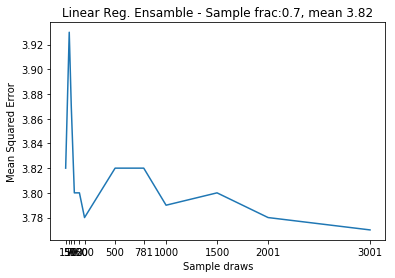

In [40]:

X_train2_scaled["Grade"] = y_train

draws = [15,50,70,100,150,200,500,781,1000,1500,2001,3001]
result = {}
sample_size=0.7

for draw_nr in draws:
    print("draws:", draw_nr)
    ensamble_dframe = pd.DataFrame()
    for i in range(0,draw_nr):
        ssample = X_train2_scaled.sample(frac=sample_size, replace=True)
        sampleX = ssample.drop(["Grade"], axis=1)
        sampleY = ssample["Grade"]
        #print(sampleX.shape)
        bregr = LinearRegression(normalize=False)
        bregr.fit(sampleX, sampleY)

        y_pred2 = bregr.predict(X_test2_scaled)
        ensamble_dframe[i] = y_pred2
        #print("BR Mean absolute error: %.5f"% metrics.mean_absolute_error(y_test, y_pred2))
        #print('BR Variance score: %.2f' % metrics.r2_score(y_test, y_pred2))
    
    
    ensamble_predict = ensamble_dframe.mean(axis=1).values
    # round up gives even better result
    ensamble_predict = np.ceil(ensamble_predict)
    mae = metrics.mean_absolute_error(y_test, ensamble_predict)
    r2 = metrics.r2_score(y_test, ensamble_predict)
    mse = np.round(np.sqrt(metrics.mean_squared_error(y_test, ensamble_predict)),2)
    #print("LR Mean Absolute Error : %.5f"% mae)
    print("LR Mean Squared Error : %.5f"% mse)
    print('LR Variance score: %.2f' % r2)
    result[draw_nr] = mse
    
## Plot
lists = sorted(result.items(), reverse=True) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.xticks(draws)
numbers = [result[key] for key in result]
mean_ = statistics.mean(numbers)
print(mean_)
#plt.yticks(result.values())
plt.title("Linear Reg. Ensamble - Sample frac:"+str(sample_size)+", mean "+str(np.round(mean_,2)))
plt.xlabel("Sample draws")
plt.ylabel("Mean Squared Error")
plt.show()


### Regression Ensamble results

In [41]:
ensamble_predict = ensamble_dframe.mean(axis=1).values
# round up gives even better result
ensamble_predict = np.ceil(ensamble_predict)
print("LR Root Squared Error: %.5f"% np.round(np.sqrt(metrics.mean_squared_error(y_test, ensamble_predict)),2))
print("LR Mean absolute error: %.5f"% metrics.mean_absolute_error(y_test, ensamble_predict))
print('LR Variance score: %.2f' % metrics.r2_score(y_test, ensamble_predict))

LR Root Squared Error: 3.77000
LR Mean absolute error: 2.84000
LR Variance score: 0.39


In [42]:
ensamble_predict<0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

## Kaggle Submission 

In [62]:
X_Train = df_dummy_train#[important_features]
X_Test = df_dummy_test#[important_features]

#X_Train.drop(["Grade"], axis=1, inplace=True)
# scale train and test data
scaler = preprocessing.StandardScaler().fit(X_Train)
X_Train_scaled = scaler.transform(X_Train)
X_Test_scaled = scaler.transform(X_Test)

X_Train_sdf = pd.DataFrame(X_Train_scaled, columns=X_Train.columns, index=X_Train.index)
X_Test_sdf = pd.DataFrame(X_Test_scaled, columns=X_Test.columns, index=X_Test.index)

In [47]:
X_Train.shape

(198, 57)

### simple submit

In [73]:
#X_Train_sdf.drop(["Grade"], axis=1, inplace=True)
degree = 2
poly = PolynomialFeatures(degree=degree)
X_train_poly2 = poly.fit_transform(X_Train_sdf)
X_test_poly2 = poly.transform(X_Test_sdf)
# bayesian regression
bregr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=5, random_state=1607, loss='ls')
bregr.fit(X_train_poly2, train_grade_values)

# Make predictions using the testing set
y_pred2 = bregr.predict(X_test_poly2)

# bayesian regression
#X_Train_sdf.drop(["Grade"], axis=1, inplace=True)
#bregr = Ridge(fit_intercept=True, normalize=True,max_iter=1500 ,alpha=0.3, tol=0.001)
#bregr.fit(X_Train_sdf, train_grade_values)

# Make predictions using the testing set
y_pred_submit = y_pred2#bregr.predict(X_Test_sdf)
# round
y_pred_submit = np.ceil(y_pred_submit)
y_pred_submit[y_pred_submit < 0] = 0

### ensamble submit

In [80]:
X_Train_sdf["Grade"] = train_grade_values
ensamble_dframe = pd.DataFrame()
for i in range(0,3001):
    print("predict:",i)
    ssample = X_Train_sdf.sample(frac=0.65, replace=True)
    sampleX = ssample.drop(["Grade"], axis=1)
    sampleY = ssample["Grade"]
    #print(sampleX.shape)
    bregr = Ridge(fit_intercept=True, normalize=True,max_iter=1500 ,alpha=0.3, tol=0.001)
    bregr.fit(sampleX, sampleY)
    
    y_pred2 = bregr.predict(X_Test_sdf)
    ensamble_dframe[i] = y_pred2

predict: 0
predict: 1
predict: 2
predict: 3
predict: 4
predict: 5
predict: 6
predict: 7
predict: 8
predict: 9
predict: 10
predict: 11
predict: 12
predict: 13
predict: 14
predict: 15
predict: 16
predict: 17
predict: 18
predict: 19
predict: 20
predict: 21
predict: 22
predict: 23
predict: 24
predict: 25
predict: 26
predict: 27
predict: 28
predict: 29
predict: 30
predict: 31
predict: 32
predict: 33
predict: 34
predict: 35
predict: 36
predict: 37
predict: 38
predict: 39
predict: 40
predict: 41
predict: 42
predict: 43
predict: 44
predict: 45
predict: 46
predict: 47
predict: 48
predict: 49
predict: 50
predict: 51
predict: 52
predict: 53
predict: 54
predict: 55
predict: 56
predict: 57
predict: 58
predict: 59
predict: 60
predict: 61
predict: 62
predict: 63
predict: 64
predict: 65
predict: 66
predict: 67
predict: 68
predict: 69
predict: 70
predict: 71
predict: 72
predict: 73
predict: 74
predict: 75
predict: 76
predict: 77
predict: 78
predict: 79
predict: 80
predict: 81
predict: 82
predict: 83
pr

predict: 701
predict: 702
predict: 703
predict: 704
predict: 705
predict: 706
predict: 707
predict: 708
predict: 709
predict: 710
predict: 711
predict: 712
predict: 713
predict: 714
predict: 715
predict: 716
predict: 717
predict: 718
predict: 719
predict: 720
predict: 721
predict: 722
predict: 723
predict: 724
predict: 725
predict: 726
predict: 727
predict: 728
predict: 729
predict: 730
predict: 731
predict: 732
predict: 733
predict: 734
predict: 735
predict: 736
predict: 737
predict: 738
predict: 739
predict: 740
predict: 741
predict: 742
predict: 743
predict: 744
predict: 745
predict: 746
predict: 747
predict: 748
predict: 749
predict: 750
predict: 751
predict: 752
predict: 753
predict: 754
predict: 755
predict: 756
predict: 757
predict: 758
predict: 759
predict: 760
predict: 761
predict: 762
predict: 763
predict: 764
predict: 765
predict: 766
predict: 767
predict: 768
predict: 769
predict: 770
predict: 771
predict: 772
predict: 773
predict: 774
predict: 775
predict: 776
predict: 777

predict: 1358
predict: 1359
predict: 1360
predict: 1361
predict: 1362
predict: 1363
predict: 1364
predict: 1365
predict: 1366
predict: 1367
predict: 1368
predict: 1369
predict: 1370
predict: 1371
predict: 1372
predict: 1373
predict: 1374
predict: 1375
predict: 1376
predict: 1377
predict: 1378
predict: 1379
predict: 1380
predict: 1381
predict: 1382
predict: 1383
predict: 1384
predict: 1385
predict: 1386
predict: 1387
predict: 1388
predict: 1389
predict: 1390
predict: 1391
predict: 1392
predict: 1393
predict: 1394
predict: 1395
predict: 1396
predict: 1397
predict: 1398
predict: 1399
predict: 1400
predict: 1401
predict: 1402
predict: 1403
predict: 1404
predict: 1405
predict: 1406
predict: 1407
predict: 1408
predict: 1409
predict: 1410
predict: 1411
predict: 1412
predict: 1413
predict: 1414
predict: 1415
predict: 1416
predict: 1417
predict: 1418
predict: 1419
predict: 1420
predict: 1421
predict: 1422
predict: 1423
predict: 1424
predict: 1425
predict: 1426
predict: 1427
predict: 1428
predic

predict: 1990
predict: 1991
predict: 1992
predict: 1993
predict: 1994
predict: 1995
predict: 1996
predict: 1997
predict: 1998
predict: 1999
predict: 2000
predict: 2001
predict: 2002
predict: 2003
predict: 2004
predict: 2005
predict: 2006
predict: 2007
predict: 2008
predict: 2009
predict: 2010
predict: 2011
predict: 2012
predict: 2013
predict: 2014
predict: 2015
predict: 2016
predict: 2017
predict: 2018
predict: 2019
predict: 2020
predict: 2021
predict: 2022
predict: 2023
predict: 2024
predict: 2025
predict: 2026
predict: 2027
predict: 2028
predict: 2029
predict: 2030
predict: 2031
predict: 2032
predict: 2033
predict: 2034
predict: 2035
predict: 2036
predict: 2037
predict: 2038
predict: 2039
predict: 2040
predict: 2041
predict: 2042
predict: 2043
predict: 2044
predict: 2045
predict: 2046
predict: 2047
predict: 2048
predict: 2049
predict: 2050
predict: 2051
predict: 2052
predict: 2053
predict: 2054
predict: 2055
predict: 2056
predict: 2057
predict: 2058
predict: 2059
predict: 2060
predic

predict: 2584
predict: 2585
predict: 2586
predict: 2587
predict: 2588
predict: 2589
predict: 2590
predict: 2591
predict: 2592
predict: 2593
predict: 2594
predict: 2595
predict: 2596
predict: 2597
predict: 2598
predict: 2599
predict: 2600
predict: 2601
predict: 2602
predict: 2603
predict: 2604
predict: 2605
predict: 2606
predict: 2607
predict: 2608
predict: 2609
predict: 2610
predict: 2611
predict: 2612
predict: 2613
predict: 2614
predict: 2615
predict: 2616
predict: 2617
predict: 2618
predict: 2619
predict: 2620
predict: 2621
predict: 2622
predict: 2623
predict: 2624
predict: 2625
predict: 2626
predict: 2627
predict: 2628
predict: 2629
predict: 2630
predict: 2631
predict: 2632
predict: 2633
predict: 2634
predict: 2635
predict: 2636
predict: 2637
predict: 2638
predict: 2639
predict: 2640
predict: 2641
predict: 2642
predict: 2643
predict: 2644
predict: 2645
predict: 2646
predict: 2647
predict: 2648
predict: 2649
predict: 2650
predict: 2651
predict: 2652
predict: 2653
predict: 2654
predic

In [81]:
ensamble_predict = ensamble_dframe.mean(axis=1).values
# round up gives even better result
ensamble_predict = np.ceil(ensamble_predict)

In [74]:
submit_df = pd.DataFrame({'id': test_ID_rows, 'Grade': y_pred_submit})
submit_df = submit_df[['id','Grade']]
submit_df

,id,Grade
0,312,10.0
1,164,10.0
2,245,7.0
3,303,11.0
4,260,12.0
5,376,10.0
6,86,12.0
7,375,6.0
8,367,13.0
9,6,14.0


In [75]:
import csv
submit_df.to_csv("student_grade_prediction.csv", index=False, header=True, quoting=csv.QUOTE_NONNUMERIC)